# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: `Team 07`
* Students: `Mathieu Lamiot, Julien Heitmann, Louis Landelle, Mathias Goncalves`
* Dataset: `US Senators`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [3]:
adjacency = np.load("adjacency.npy")
n_nodes =  adjacency.shape[0]

## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [74]:
degree_vect = np.sum(adjacency,axis=1)
degree_matrix = np.diag(degree_vect)

laplacian_combinatorial = degree_matrix-adjacency

d_inv_sqrt = np.diag(np.power(degree_vect, -0.5, where = degree_vect>0))
laplacian_normalized = d_inv_sqrt.dot(laplacian_combinatorial).dot(d_inv_sqrt)

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

In [23]:
laplacian =  laplacian_combinatorial
laplacian_csr = scipy.sparse.csr_matrix(laplacian)

### Question 2

Compute the eigendecomposition of the Laplacian $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [76]:
# Using non-sparse laplacian
eigenvalues, eigenvectors = scipy.linalg.eigh(laplacian)
eigenvalues_normalized, eigenvectors_normalized = scipy.linalg.eigh(laplacian_normalized)

# Using sparse laplacian - Missing the last eigenvalue
eigenvalues2, eigenvectors2 = sparse.linalg.eigsh(laplacian_csr, k= n_nodes-1)

assert eigenvectors.shape == (n_nodes, n_nodes)

Justify your choice of eigensolver.

We first tried to take advantage of the sparsity of the laplacian matrix, but unforutnately scipy methods for solving eigenproblems with CSR formatted matrix can't return all the eigenvalues and eigenvectors (k has to be < `n_node`). This limitation prevented us from passing the assertion.
So we ended up going for `scipy.linalg.eigh()`, which works on a dense formatted matrix. Since our graph undirected, the lapacian is real symetric matrix to we can use `scipy.linalg.eigh()` instead of `scipy.linalg.eig()`.

Since our network is relatively small, computation time is still faste enough, even without taking advantage of sparsity. Note that both methods return similar results (except for the last eigenvalue, not returned by the sparse method.)

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

It is the incidence matrix. As our graph is weighted and undirected, we took a definition adpated from the one presented in class. It is defined as :

$S(i,j) = W_{(i,k)} \ if e_j=\{v_i,v_k\}\ and \ i<k \ for \ some \ k $

$S(i,j) = -W_{(i,k)} \ if e_j=\{v_i,v_k\}\ and \ i>k \ for \ some \ k $

$S(i,j) = 0 \ otherwise$

Basically, we make our graph directed (from low-indice vertices to high-indice vertices) is order to be able to apply the definition seen in class. Doing so, the property $L = S S^\top$ holds, and the the "smoothness of a signal" notion is preserved, as discussed in the following.

### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

**Your answer here.**

$\| S^\top u_k \|_2^2 = <S^\top u_k,S^\top u_k> = u_k^\top S S^\top u_k  = u_k^\top L u_k $

$u_k$ being the k-th eigenvector of L: 

$\| S^\top u_k \|_2^2 = \lambda_k <u_k,u_k>$

Hence: 

$\| S^\top u_k \|_2^2 = \lambda_k$ 

What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

**Your answer here.**

Consider the k-th element of x as a value assigned to the k-th node of the network. Hence x can be seen as a signal over the network. Let $y = S^\top x $. 

Then, the k-th element of y is the difference of the signal x between the two nodes linked by the k-th vertex of the network (multiply by its weigth).

Hence, $\| S^\top x \|_2^2$ is the sum of the squares of those differences. It is a measure of the variations of the signal x on the network. High values means a non-smooth signal over the network, whereas small values reflect a signal with low variation across the network.

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

**Your annswer here.**

$u_0$ is an indicator function of a connected component of the graph. In our graph, we have one isolated node and the 99 others nodes form a connected component. Hence, we have twice the eigenvalue 0. $u_0$ and $u_1$ are the indicator functions of those 2 connected components, normalized. So they have positive values over the related connected components, and have zero value elsewhere.

In [81]:
#Indicator function of the first connected component: An isolated node.
eigenvectors[:,0]

array([-6.55247369e-49, -7.29564752e-17, -1.41259984e-16,  2.26461385e-16,
        8.72117092e-17, -6.96735265e-17,  2.98872226e-18,  9.42234102e-17,
        1.15292555e-16, -5.19289266e-17,  3.70786729e-17,  8.89999659e-17,
       -4.48532196e-17,  6.12033881e-17,  8.14721110e-18, -2.36668687e-17,
        2.77440081e-17, -1.52954248e-16, -1.57338491e-17,  6.30949612e-17,
        8.32568181e-20, -1.05684123e-16, -6.80430421e-17,  8.83474809e-17,
        6.85194950e-17, -8.85261120e-19,  8.70414033e-19, -4.76366332e-17,
        7.62505098e-17,  1.96690358e-18, -7.62304005e-17,  1.14626587e-16,
        9.91150032e-18, -7.46951482e-17,  2.83950086e-18,  1.13087504e-16,
       -7.07379058e-17,  1.51779518e-18, -2.02816444e-19,  8.25057112e-17,
       -6.05225024e-18, -1.62124163e-18, -3.86203744e-18,  2.21646003e-17,
       -4.58485670e-17, -3.14680976e-18,  7.57285408e-18, -2.32597617e-17,
       -1.05582053e-16,  1.15835487e-18, -1.35353421e-16, -4.62204618e-20,
        2.03065700e-18, -

In [38]:
#Indicator function of the second connected component: 99 nodes.
eigenvectors[:,1]

array([0.10050378, 0.10050378, 0.10050378, 0.10050378, 0.10050378,
       0.10050378, 0.10050378, 0.10050378, 0.10050378, 0.10050378,
       0.10050378, 0.10050378, 0.10050378, 0.10050378, 0.10050378,
       0.10050378, 0.10050378, 0.10050378, 0.10050378, 0.10050378,
       0.10050378, 0.10050378, 0.10050378, 0.10050378, 0.10050378,
       0.10050378, 0.10050378, 0.10050378, 0.10050378, 0.10050378,
       0.10050378, 0.10050378, 0.10050378, 0.10050378, 0.10050378,
       0.10050378, 0.10050378, 0.10050378, 0.10050378, 0.10050378,
       0.10050378, 0.10050378, 0.10050378, 0.10050378, 0.10050378,
       0.10050378, 0.10050378, 0.10050378, 0.10050378, 0.10050378,
       0.10050378, 0.10050378, 0.10050378, 0.10050378, 0.        ,
       0.10050378, 0.10050378, 0.10050378, 0.10050378, 0.10050378,
       0.10050378, 0.10050378, 0.10050378, 0.10050378, 0.10050378,
       0.10050378, 0.10050378, 0.10050378, 0.10050378, 0.10050378,
       0.10050378, 0.10050378, 0.10050378, 0.10050378, 0.10050

### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

Text(0, 0.5, 'Eigenvalue')

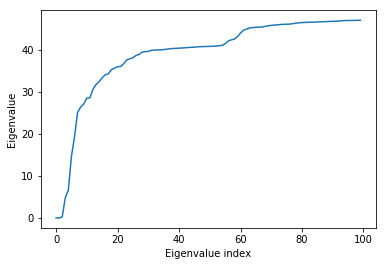

In [78]:
# Your code here.
plt.plot(eigenvalues)
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')

**Your answer here.**

The eigenvalues quickly increase: there are just a few low eigenvalues. This tends to show that, apart from the disconnected node, the network is well connected.

How many connected components are there in your graph? Answer using the eigenvalues only.

In [83]:
# Your code here.
tol = 10**(-5);
nCC = np.sum(eigenvalues<tol)

print("Number of connected components: " + str(nCC))

Number of connected components: 2


Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

**Your answer here.**

Eigenvalues of the combinatorial laplacian are upper-bounded by $2*degree_{max}$.

Eigenvalues of the normalized laplacian are upper-bounded by 2.

This comes from the Gershgorin circle theorem applied to the specific structure of the Laplacian.

## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

**Your answer here.**

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [ ]:
# Your code here.

Plot the nodes embedded in 2D. Comment on what you see.

In [ ]:
# Your code here.

**Your answer here.**

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

**Your answer here.**

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

**Your answer here.**

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

In [ ]:
# Your code here.

### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

In [ ]:
# Your code here.

**Your answer here.**

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

In [ ]:
# Your code here.

### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

In [ ]:
# Your code here.

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**Your answer here.**